In [3]:
from utils import *
pd.set_option('display.max_columns', None)

In [156]:
update_noaa_data()

In [ ]:
update_OM_data()

In [4]:
def load_NOAA_df(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()
    df['date'] = pd.to_datetime(df['date'])
    return df

def load_OM_df(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()
    df['date'] = df['date'].str.split(' ').str[0]
    df['date'] = pd.to_datetime(df['date'])
    return df

In [5]:
noaa_df_Chicago = load_NOAA_df('data/Chicago_NOAA.csv')
om_df_Chicago = load_OM_df('data/Chicago_OM.csv')
noaa_df_NYC = load_NOAA_df('data/NYC_NOAA.csv')
om_df_NYC = load_OM_df('data/NYC_OM.csv')

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PLot maxtemperature
fig = make_subplots(rows=2, cols=1, subplot_titles=("NYC NOAA", "NYC OM"))
fig.add_trace(go.Scatter(x=noaa_df_NYC['date'], y=noaa_df_NYC['maxtemperature'], name='Max Temperature'), row=1, col=1)
fig.add_trace(go.Scatter(x=om_df_NYC['date'], y=om_df_NYC['temperature_2m_max'], name='Max Temperature'), row=2, col=1)
fig.update_layout(height=600, width=800, title_text="Max Temperature")
fig.show()

In [17]:
import numpy as np

def update_df_merge(old_df, om_df):
    df = old_df.copy()

    # cycle features
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_year']/365)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_year']/365)

    # drop AtObsTemperature
    df = df.drop(columns=['atobstemperature', 'snowfallnormal', 'snowfalldeparture', 'snowdepth', 'avgtemperature', 'avgtemperaturedeparture', 'cdd', 'hdddeparture', 'cdddeparture', 'gdd', 'hdd'])

    # Fill missing values
    max_temp_om_dict = om_df.set_index('date')['temperature_2m_max'].to_dict()
    min_temp_om_dict = om_df.set_index('date')['temperature_2m_min'].to_dict()
    snowfall_om_dict = om_df.set_index('date')['snowfall_sum'].to_dict()
    precipitation_om_dict = om_df.set_index('date')['precipitation_sum'].to_dict()
    

    def fill_missing_from_dict(row, column_name, reference_dict):
        if pd.isna(row[column_name]):
            return reference_dict.get(row['date'], np.nan)
        return row[column_name]

    # Apply custom function
    df['maxtemperature'] = df.apply(fill_missing_from_dict, args=('maxtemperature', max_temp_om_dict), axis=1)
    df['mintemperature'] = df.apply(fill_missing_from_dict, args=('mintemperature', min_temp_om_dict), axis=1)
    df['snowfall'] = df.apply(fill_missing_from_dict, args=('snowfall', snowfall_om_dict), axis=1)
    
    
    # Recalcualte departure
    df['maxtemperaturedeparture'] = df['maxtemperature'] - df['maxtemperaturenormal']
    df['mintemperaturedeparture'] = df['mintemperature'] - df['mintemperaturenormal']
    
    # Reverse calculate precipitation from precipitation normal and departure
    df['precipitation'] = df['precipitationnormal'] + df['precipitationdeparture']
    
    df['precipitation'] = df.apply(fill_missing_from_dict, args=('precipitation', precipitation_om_dict), axis=1)
    df['precipitationdeparture'] = df['precipitation'] - df['precipitationnormal']
    
    # Add future values (these are technically past values since they calculate the normal of previous years)
    df['next_day_max_temp_normal'] = df['maxtemperaturenormal'].shift(-1)
    df['next_day_min_temp_normal'] = df['mintemperaturenormal'].shift(-1)
    df['next_day_avg_temp_normal'] = df['avgtemperaturenormal'].shift(-1)
    df['next_day_precipitation_normal'] = df['precipitationnormal'].shift(-1)
    df['next_day_CDD_normal'] = df['cddnormal'].shift(-1)
    df['next_day_HDD_normal'] = df['hddnormal'].shift(-1)
    
    # merge the OM data
    df = df.merge(om_df, on='date', how='left')
    
    # Target 
    df['next_day_max_temp'] = df['maxtemperature'].shift(-1)
    
    # drop the final row
    last_row = df.iloc[-2]
    df = df[:-2]
    
    df = df.dropna()
    
    return df, last_row

def update_df_solo(old_df):
    df = old_df.copy()

    # cycle features
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_year']/365)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_year']/365)
    
    # drop AtObsTemperature
    df = df.drop(columns=['atobstemperature', 'snowdepth'])
    
    df['precipitation'] = df['precipitationnormal'] + df['precipitationdeparture']
    df['snowfall'] = df['snowfallnormal'] + df['snowfalldeparture']
    
    # Carry future values.
    df['next_day_max_temp_normal'] = df['maxtemperaturenormal'].shift(-1)
    df['next_day_min_temp_normal'] = df['mintemperaturenormal'].shift(-1)
    df['next_day_avg_temp_normal'] = df['avgtemperaturenormal'].shift(-1)
    df['next_day_precipitation_normal'] = df['precipitationnormal'].shift(-1)
    df['next_day_CDD_normal'] = df['cddnormal'].shift(-1)
    df['next_day_HDD_normal'] = df['hddnormal'].shift(-1)
    
    # Target 
    df['next_day_max_temp'] = df['maxtemperature'].shift(-1)
    
    # drop the final row
    last_row = df.iloc[-2]
    df = df[:-2]
    
    # df = df.dropna()
    
    return df, last_row

In [18]:
data, predictor = update_df_solo(noaa_df_NYC)
data.tail()

,date,maxtemperature,maxtemperaturenormal,maxtemperaturedeparture,mintemperature,mintemperaturenormal,mintemperaturedeparture,avgtemperature,avgtemperaturenormal,avgtemperaturedeparture,precipitation,precipitationnormal,precipitationdeparture,snowfall,snowfallnormal,snowfalldeparture,hdd,hddnormal,hdddeparture,cdd,cddnormal,cdddeparture,gdd,day,month,year,day_of_year,sin_day,cos_day,next_day_max_temp_normal,next_day_min_temp_normal,next_day_avg_temp_normal,next_day_precipitation_normal,next_day_CDD_normal,next_day_HDD_normal,next_day_max_temp
56685,2024-03-14,74.0,49.0,25.0,46.0,35.1,10.9,60.0,42.1,17.9,0.0,0.14,-0.14,0.0,0.1,-0.1,5.0,23.0,-18.0,0.0,0.0,0.0,10.0,14,3,2024,74,0.956235,0.292600,49.3,35.4,42.3,0.14,0.0,22.7,73.0
56686,2024-03-15,73.0,49.3,23.7,51.0,35.4,15.6,62.0,42.3,19.7,0.0,0.14,-0.14,0.0,0.2,-0.2,3.0,22.7,-19.7,0.0,0.0,0.0,12.0,15,3,2024,75,0.961130,0.276097,49.7,35.6,42.6,0.15,0.0,22.4,61.0
56687,2024-03-16,61.0,49.7,11.3,47.0,35.6,11.4,54.0,42.6,11.4,0.0,0.15,-0.15,0.0,0.2,-0.2,11.0,22.4,-11.4,0.0,0.0,0.0,4.0,16,3,2024,76,0.965740,0.259512,50.0,35.9,42.9,0.14,0.0,22.1,63.0
56688,2024-03-17,63.0,50.0,13.0,48.0,35.9,12.1,55.5,42.9,12.6,0.0,0.14,-0.14,0.0,0.1,-0.1,9.0,22.1,-13.1,0.0,0.0,0.0,6.0,17,3,2024,77,0.970064,0.242850,50.3,36.1,43.2,0.15,0.0,21.8,51.0
56689,2024-03-18,51.0,50.3,0.7,38.0,36.1,1.9,44.5,43.2,1.3,0.0,0.15,-0.15,0.0,0.1,-0.1,20.0,21.8,-1.8,0.0,0.0,0.0,0.0,18,3,2024,78,0.974100,0.226116,50.7,36.4,43.5,0.15,0.0,21.5,48.0


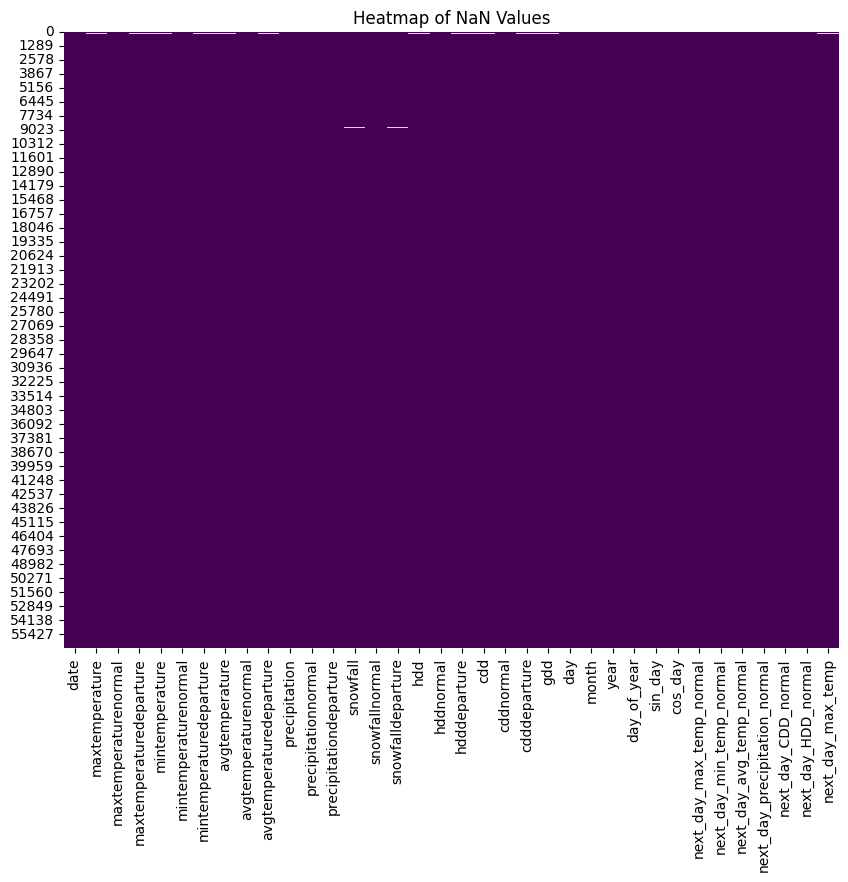

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'data'
# Create a mask for NaN values
nan_mask = data.isna()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(nan_mask, cbar=False, cmap='viridis')
plt.title('Heatmap of NaN Values')
plt.show()

In [ ]:
# PLot maxtemperature
fig = make_subplots(rows=3, cols=1, subplot_titles=("Chicago NOAA", "Chicago OM"))
fig.add_trace(go.Scatter(x=noaa_df_Chicago['date'], y=noaa_df_Chicago['maxtemperature'], name='Max Temperature'), row=1, col=1)
fig.add_trace(go.Scatter(x=om_df_Chicago['date'], y=om_df_Chicago['temperature_2m_max'], name='Max Temperature'), row=2, col=1)
fig.add_trace(go.Scatter(x=data['date'], y=data['maxtemperature'], name='Max Temperature'), row=3, col=1)
fig.update_layout(height=600, width=800, title_text="Max Temperature")
fig.show()

In [ ]:
# for each column in noaa_data_Austin print the number of missing values
for column in data.columns:
    print(f'{column} has {data[column].isna().sum()} missing values')